# SEP - Level Acceleration
The following is taken from National Test Pilot School. ‘Vol. 03 Fixed-Wing Performance Flight Testing’, 2021.

## Required Equations

$$
\left. \frac{dH}{dt}\right|_t = \text{SEP} = \frac{V_T}{g}\frac{dV_t}{dt}
$$

### Variables

## Pilot's Data

## Order of Analysis

1. Vi corrected for instrument and position error and compressibility -> to TAS (knowing PA and ambient temperature)
1. Plot $V_T$ versus time. Assuming no climb/descent the tangent to the curve at any airspeed can be measured and a rate of climb calculated using the equation
$$
\left. \frac{dH}{dt}\right|_t = \text{SEP} = \frac{V_T}{g}\frac{dV_t}{dt}
$$
3. 4th Order curve fit is usually good, however, sometimes splines.
4. Correct for climbing or descents
$$
\Delta \left(\frac{dH}{dt}\right)=\left(\frac{H_{\text{final}-H_{initial}}}{\Delta t}\right)\frac{T_t}{T_s}
$$
5. Non-Standard Horsepower Available Correction
$$
\Delta \frac{dH}{dt}=\frac{550 \eta \text{BHP}_t}{W_t}\left(\sqrt{\frac{T_t}{T_s}}-1\right)
$$

6. Weight Corrections
$$
\left.\frac{dH}{dt}\right|_s = \frac{W_t}{W_s}\left.\frac{dH}{dt}\right|_t
$$

7. Summary of all corrections
$$
\left. \frac{dH}{dt} \right|_s = \frac{W_t}{W_s} \left[ \frac{T_t}{T_s} \left. \frac{dH}{dt} \right|_t  + \frac{550 \eta BHP_t}{W_t} \left( \sqrt{\frac{T_t}{T_s}} - 1 \right) + \left( \frac{H_{final} - H_{initial}}{\Delta t} \right) \frac{T_t}{T_s} + \frac{2}{\pi A R e_p V_T S} \left( \frac{W_t^2 - W_s^2}{W_t} \right)\right]
$$

### From brief:

Corrections:

1. Climb or Descent during acceleration
2. Non-standard power available
3. Inertial Weight
4. Induced Drag

Total Corrections:

$$
\left(\frac{dH}{dt}\right)_s = \left[\frac{V_T}{g}\frac{dV_T}{dt}+\frac{550 \eta \text{BHP}_s}{W_t}\left(1-\sqrt{\frac{T_s}{T_t}}\right)+\left(\frac{H_f-H_i}{\Delta t}\right)\right]\frac{W_t}{W_s}+\frac{2}{\pi \text{AR} e \rho V_T S}\left(\frac{W_t^2-W_s^2}{W_s}\right)
$$


## Python Code

In [37]:
import numpy as np
import pandas as pd

# from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

from atmosphere import Atmosphere

atm = Atmosphere()

### Constants

In [38]:
g = 32.17  # ft/s^2

### Functions

In [39]:
def calc_vt_from_vc(atm, vc_fps, h):
    qc = atm.calc_qc(vc_fps)
    Pa = atm.calc_Pa(h)
    ve_fps = atm.calc_ve(Pa, qc)
    ve = atm.fps_to_kts(ve_fps)
    vt = atm.calc_vt(ve, h)
    return vt

#### Utility Functions

In [40]:
def standardize_columns(df, column_mapping):
    # Rename columns based on the exact mapping
    df.rename(columns=column_mapping, inplace=True)
    return df

### Load Data

In [41]:
df_accel = pd.read_excel("./demo_data/level_accel_data.xlsx", header=1)
# df_accel = pd.read_excel("./demo_data/level_accel_10k_clean.xlsx")

# For level_accel_data.xlsx
column_mapping = {
    # "Column Name in Excel": "Standardized Name"
    "Time [s]": "time",
    "Vi [kts]": "V_i[kts]",
    "Hi [ft]": "Hp_i",
    "TT [℃]": "oat",
    "Wf [lbs]": "w_f",
    "ΔVic (AFM) [kts]": "delta_V_i_c[kts]",
    "ΔVpc (AFM) [kts]": "delta_V_p_c[kts]",
    "ΔVc (AFM) [kts]": "delta_V_c[kts]",
    "ΔHic (AFM) [ft]": "delta_H_i_c",
    "ΔHpc (AFM) [ft]": "delta_H_p_c",
    "Vi error [±kts]": "V_i_error[kts]",
    "Hi error [±ft]": "H_i_error[ft]",
}

# Apply standardization
dfs = [standardize_columns(df, column_mapping) for df in [df_accel]]

### Test Parameters

In [42]:
b = 38.1  # wing span [ft]
S = 255  # wing area [ft^2]
AR = b**2 / S  # aspect ratio
e = 0.8  # Oswald efficiency factor
W_s = 11900  # Standard Weight [lb]
ZFW = 9000  # lb

### Data Analysis

In [ ]:
df_accel["H_c"] = df_accel["Hp_i"] + df_accel["delta_H_i_c"] + df_accel["delta_H_p_c"]
# TODO: Altitude correction iaw with USNTPS?
df_accel["V_c[kts]"] = (
    df_accel["V_i[kts]"] + df_accel["delta_V_i_c[kts]"] + df_accel["delta_V_p_c[kts]"]
)
df_accel["V_c[fps]"] = df_accel["V_c[kts]"] * atm.kt_fps
df_accel["V_t[kts]"] = df_accel.apply(
    lambda row: calc_vt_from_vc(atm, row["V_c[fps]"], row["H_c"]), axis=1
)
df_accel["V_t[fps]"] = df_accel["V_t[kts]"] * atm.kt_fps
# TODO: why isn't atm.calc_mach taking observed ambient temperature?
# Could also use qc USNTPS mach calculation
df_accel["Mach"] = df_accel.apply(
    lambda row: atm.calc_mach(row["V_t[kts]"], row["H_c"]), axis=1
)

# numpy polyfit
# TODO: Maybe spline interpolation?
coefficients_vt = np.polyfit(df_accel["time"], df_accel["V_t[fps]"], 4)
poly_vt = np.poly1d(coefficients_vt)
df_accel["V_t[fps]_model"] = poly_vt(df_accel["time"])
df_accel["dVt/dt"] = np.gradient(df_accel["V_t[fps]_model"], df_accel["time"])
df_accel["sep"] = df_accel["V_t[fps]_model"] / g * df_accel["dVt/dt"]
# TODO: SEP corrections
df_accel["ROC[fpm]"] = df_accel["sep"] * 60
# df_accel["n_z"] =


# Fit a spline to the ROC vs. True Airspeed data
spline = UnivariateSpline(df_accel["V_t[kts]"], df_accel["ROC[fpm]"], s=0)
airspeed_smooth = np.linspace(
    df_accel["V_t[kts]"].min(), df_accel["V_t[kts]"].max(), 500
)
roc_smooth = spline(airspeed_smooth)

# Calculate the derivative of the spline (this gives us the slope of the ROC curve at each point)
spline_derivative = spline.derivative()

# Use a starting guess near the middle of the airspeed range
initial_guess = airspeed_smooth[len(airspeed_smooth) // 2]

# Solve for where the derivative is zero
peak_airspeed = fsolve(spline_derivative, initial_guess)[0]

peak_roc = spline(peak_airspeed)

print(f"Peak Rate of Climb: {peak_roc:.2f} fpm")
print(f"True Airspeed at Peak ROC: {peak_airspeed:.2f} kts")

# Find the point where the slope from (0, 0) to (V_t, ROC) matches the derivative of the curve
tangent_airspeed = None
tangent_roc = None
for vt in airspeed_smooth:
    roc_value = spline(vt)
    slope_to_origin = roc_value / vt  # Slope of the line from (0, 0) to (V_t, ROC)
    curve_slope = spline_derivative(vt)  # Slope of the ROC curve at this point

    # Check if the slopes are approximately equal
    if np.isclose(
        slope_to_origin, curve_slope, atol=1e-2
    ):  # Adjust tolerance as needed
        tangent_airspeed = vt
        tangent_roc = roc_value
        break

if tangent_airspeed is not None and tangent_roc is not None:
    print(
        f"Tangent Point: Best Angle True Airspeed = {tangent_airspeed:.2f} kts, ROC = {tangent_roc:.2f} fpm"
    )
else:
    print(
        "No tangent point found where the slope to the origin matches the derivative of the curve."
    )

Peak Rate of Climb: 2298.80 fpm
True Airspeed at Peak ROC: 266.15 kts
No tangent point found where the slope to the origin matches the derivative of the curve.


In [44]:
df_accel

,time,V_i[kts],Hp_i,oat,w_f,ZFW [lbs],delta_H_i_c,delta_H_p_c,delta_V_i_c[kts],delta_V_p_c[kts],...,H_c,V_c[kts],V_c[fps],V_t[kts],V_t[fps],Mach,V_t[fps]_model,dVt/dt,sep,ROC[fpm]
0,0,140,15000,-5,3000,9000,0,0,0,0,...,15000,140,236.29340,175.746188,296.626173,0.280751,287.120504,3.583408,31.982281,1918.936857
1,10,150,15000,-5,3000,9000,0,0,0,0,...,15000,150,253.17150,188.184784,317.620160,0.300621,322.954587,3.487836,35.014380,2100.862774
2,20,165,15000,-5,3000,9000,0,0,0,0,...,15000,165,278.48865,206.799608,349.038447,0.330358,356.877222,3.298517,36.592025,2195.521494
3,30,178,15000,-5,3000,9000,0,0,0,0,...,15000,178,300.43018,222.887898,376.192423,0.356058,388.924919,3.112667,37.631139,2257.868327
4,40,198,15000,-5,3000,9000,0,0,0,0,...,15000,198,334.18638,247.552433,417.821471,0.395459,419.130560,2.929924,38.172856,2290.371350
5,50,220,15000,-5,3000,9000,0,0,0,0,...,15000,220,371.31820,274.553451,463.394061,0.438593,447.523403,2.749926,38.254775,2295.286528
6,60,230,15000,-5,3000,9000,0,0,0,0,...,15000,230,388.19630,286.779069,484.028581,0.458123,474.129075,2.572309,37.911298,2274.677856
7,70,240,15000,-5,3000,9000,0,0,0,0,...,15000,240,405.07440,298.973788,504.610949,0.477604,498.969581,2.396711,37.173948,2230.436864
8,80,248,15000,-5,3000,9000,0,0,0,0,...,15000,248,418.57688,308.706805,521.038433,0.493152,522.063296,2.222769,36.071693,2164.301551
9,90,256,15000,-5,3000,9000,0,0,0,0,...,15000,256,432.07936,318.419202,537.431113,0.508667,543.424970,2.050122,34.631247,2077.874843



#### Plot

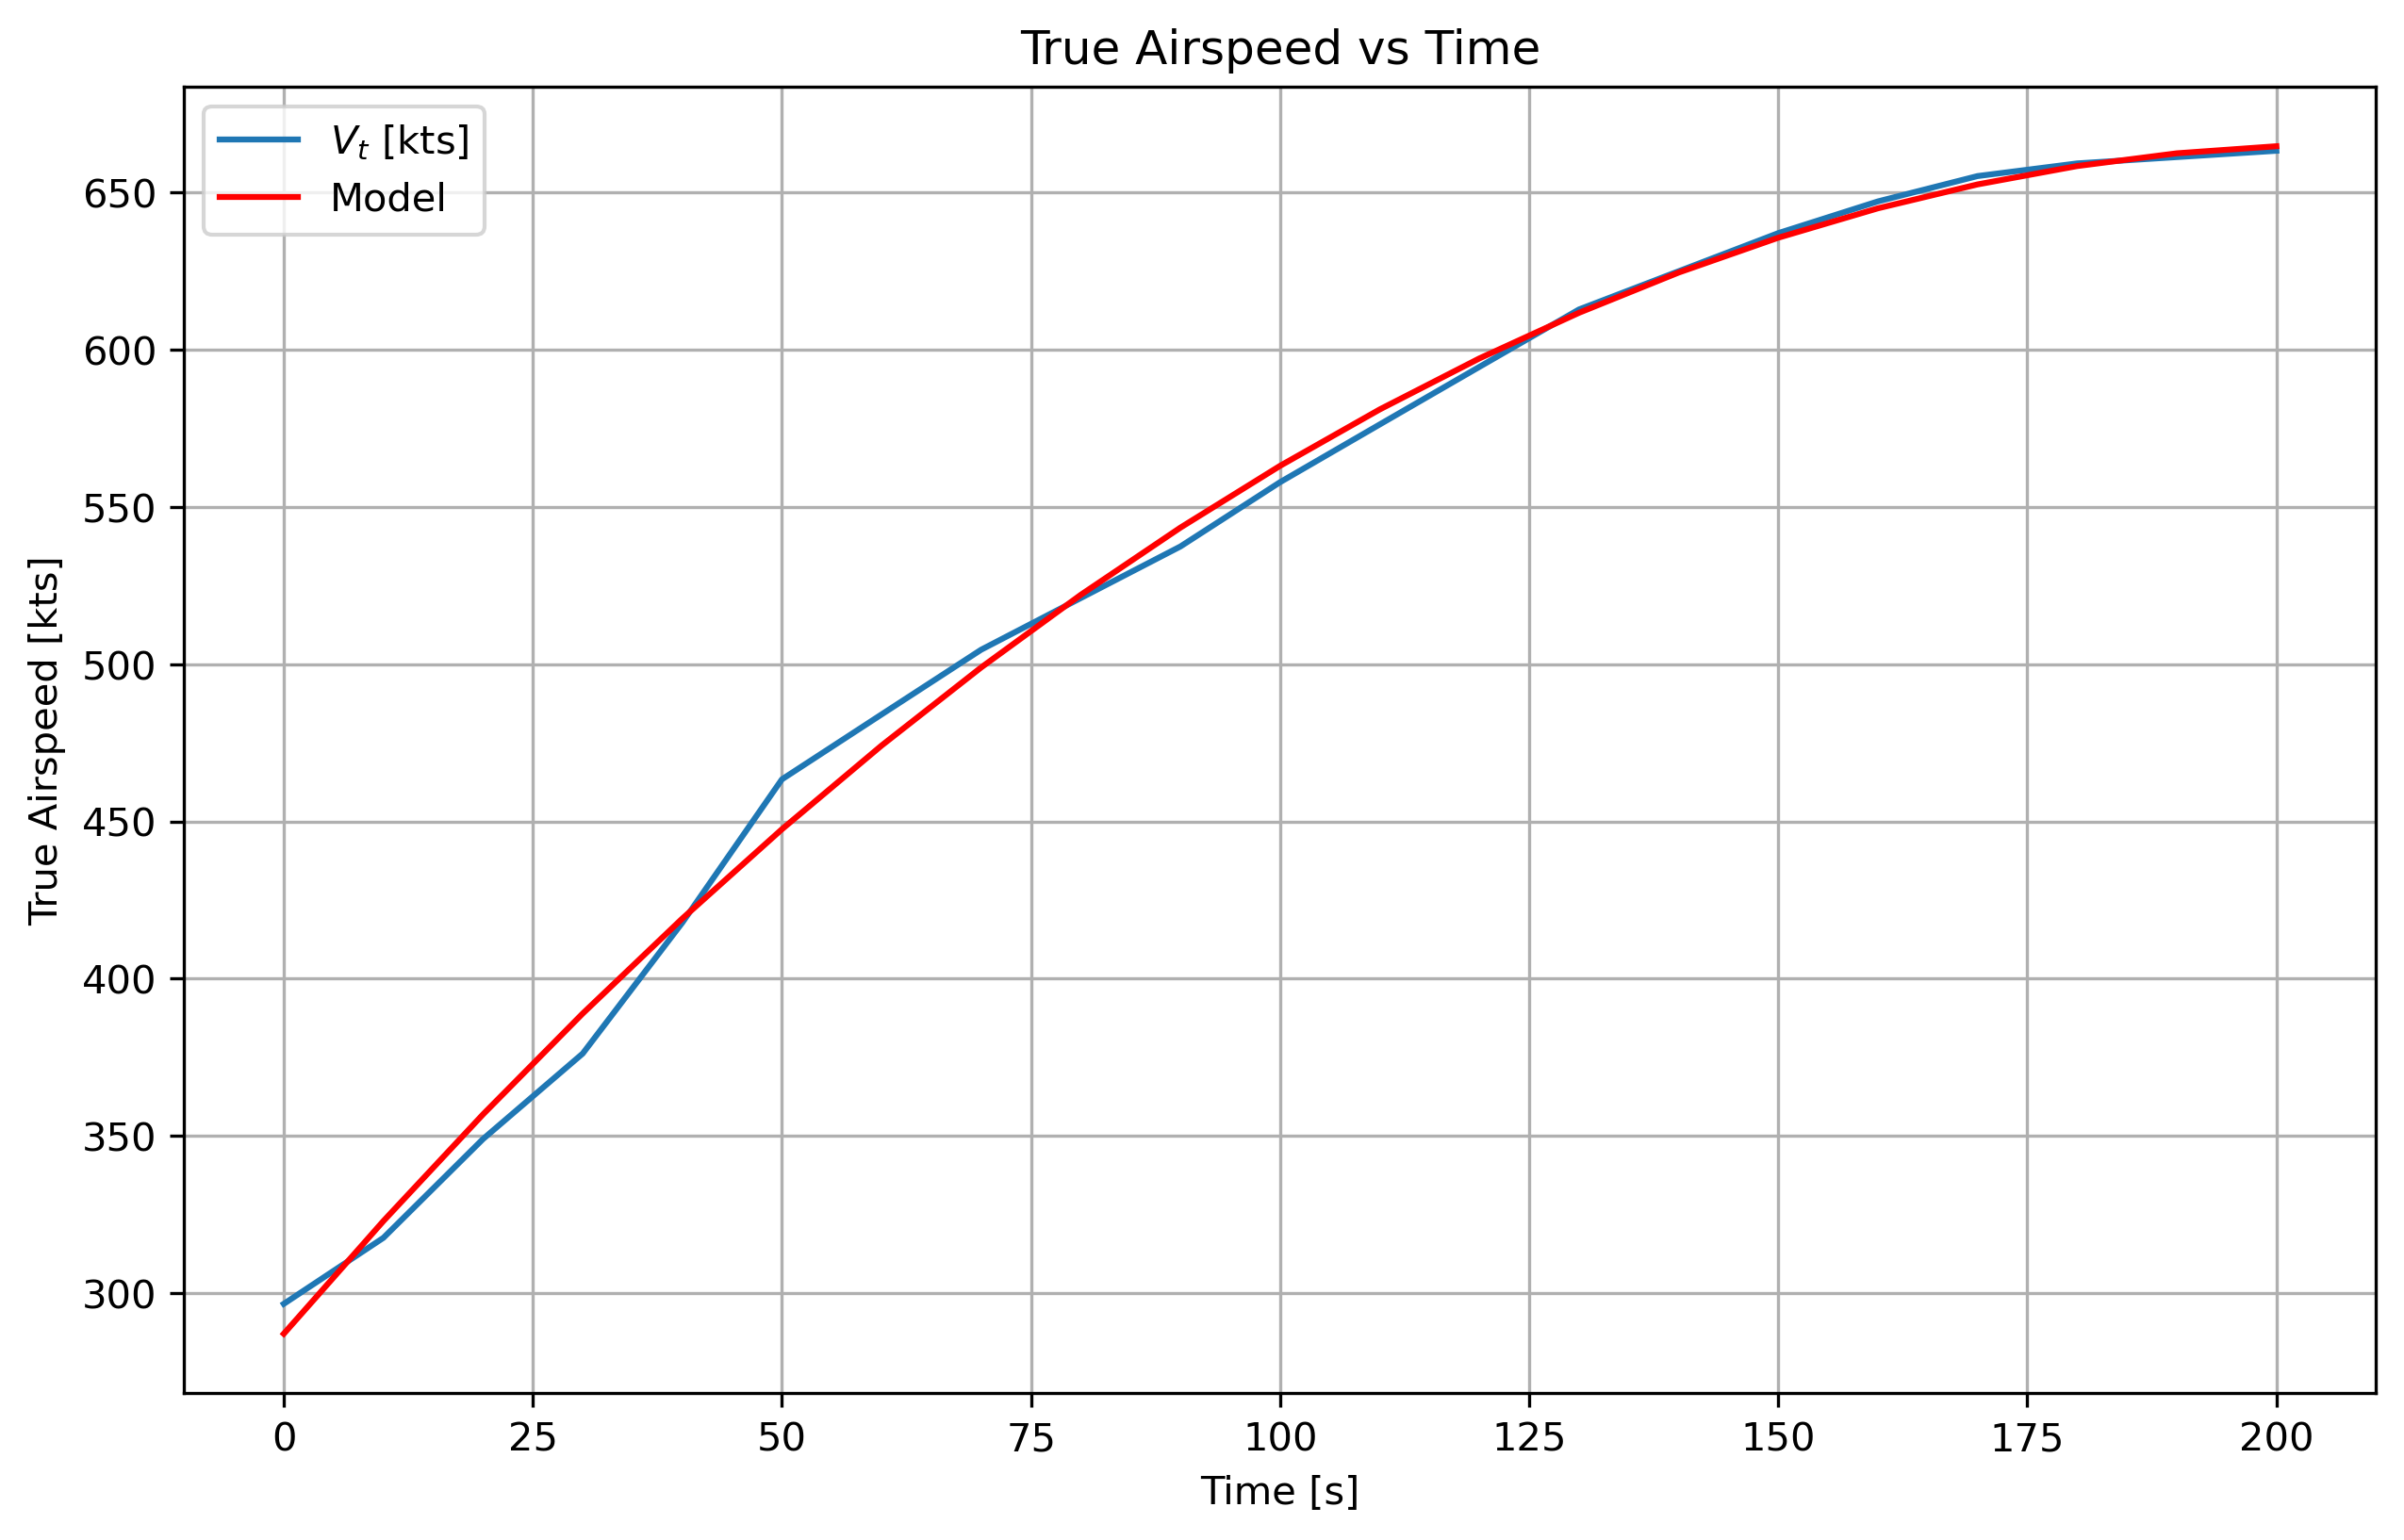

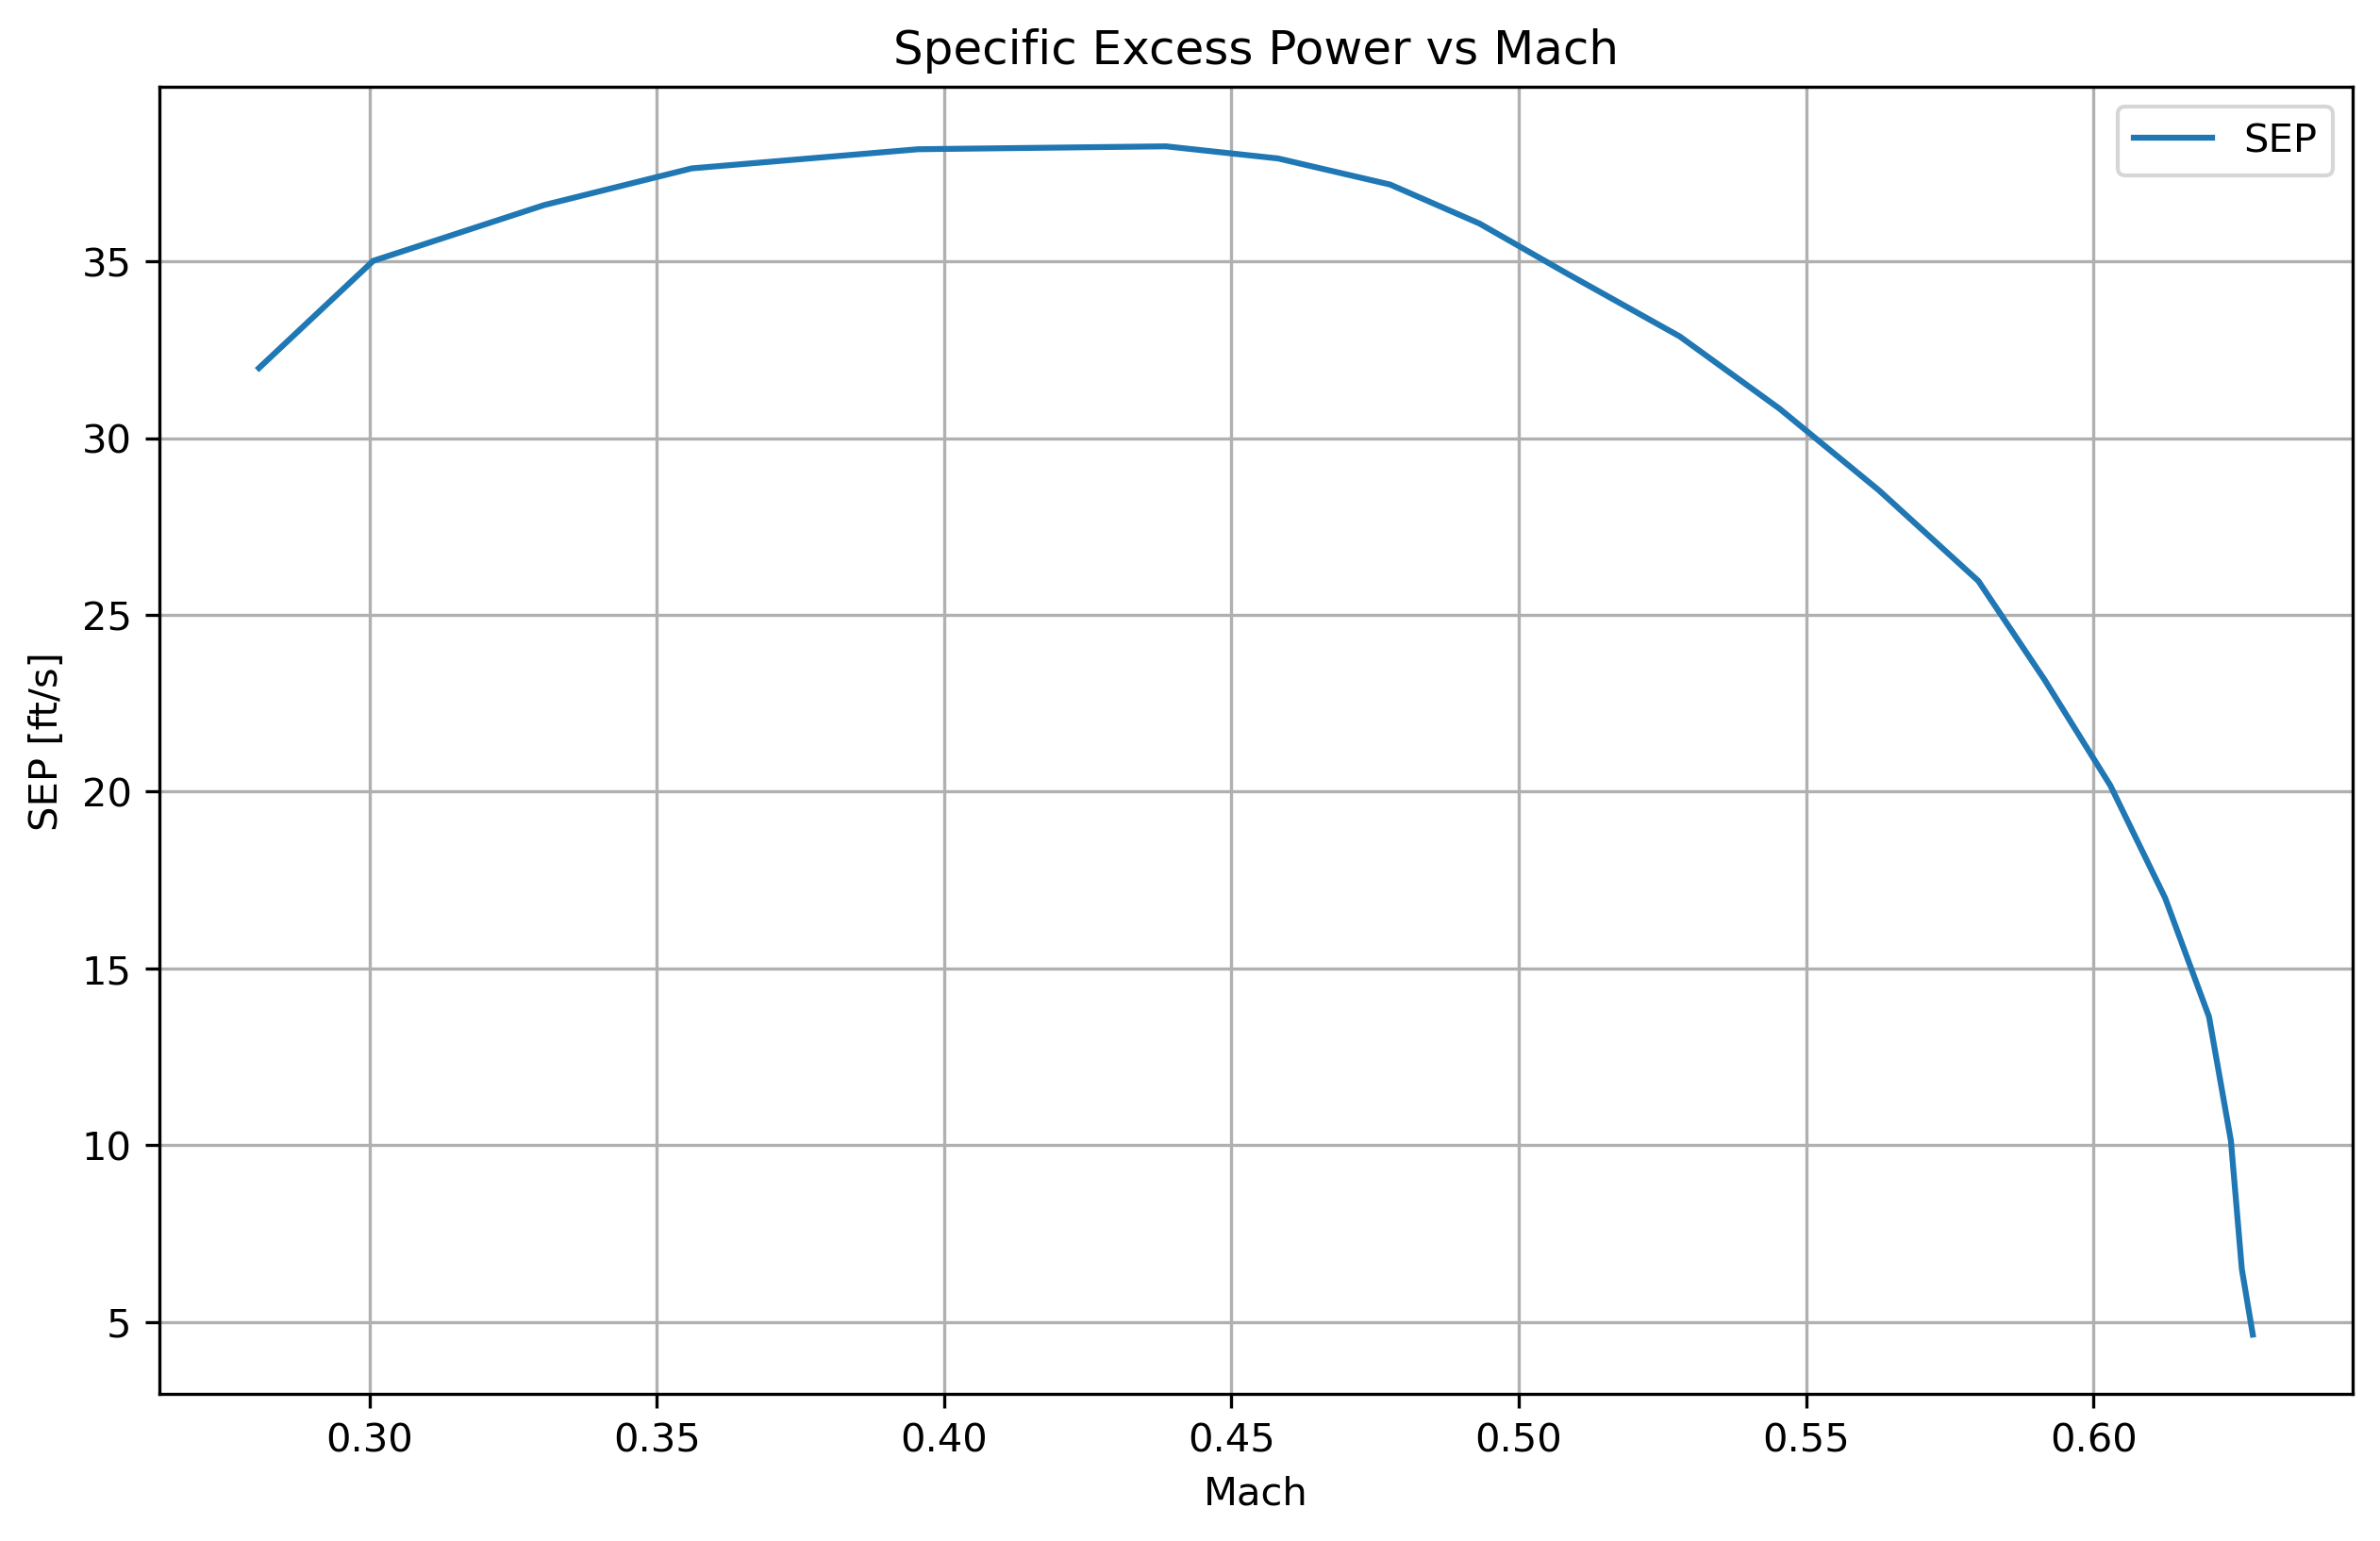

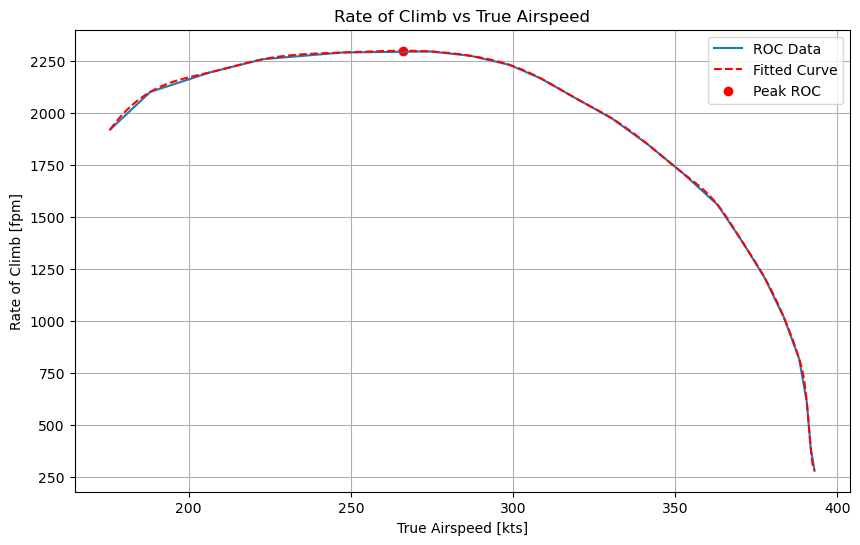

In [45]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(df_accel["time"], df_accel["V_t[fps]"], label=r"$V_t$ [kts]")
plt.plot(df_accel["time"], df_accel["V_t[fps]_model"], color="r", label="Model")
plt.xlabel("Time [s]")
plt.ylabel("True Airspeed [kts]")
plt.title("True Airspeed vs Time")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6), dpi=300)
plt.plot(df_accel["Mach"], df_accel["sep"], label=r"SEP")
plt.xlabel("Mach")
plt.ylabel("SEP [ft/s]")
plt.title("Specific Excess Power vs Mach")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(df_accel["V_t[kts]"], df_accel["ROC[fpm]"], label="ROC Data")
plt.plot(airspeed_smooth, roc_smooth, linestyle="--", color="r", label="Fitted Curve")
plt.scatter(peak_airspeed, peak_roc, color="red", label="Peak ROC")
plt.xlabel("True Airspeed [kts]")
plt.ylabel("Rate of Climb [fpm]")
plt.title("Rate of Climb vs True Airspeed")
plt.legend()
plt.grid()
plt.show()